# Trip times analysis - Summary

### Background
A dataset of ~14.3 million records was provided containing details of Lyft trips. These records contained coordinats of start and end location along with the start time of the trip. Trip duration (in seconds) was provided for ~12.9 million records (the training set). The remaining 1.3 million records did not contain trip duration and it is desired to predict duration for these records (the test set).

### Methods
Data was first explored to determine its characteristics. 

### Results
?

### Conclusion
?


In [183]:
# display output from all cmds just like Python shell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import platform
print('python.version = ', platform.python_version())
import IPython
print('ipython.version =', IPython.version_info)

import numpy as np
print('numpy.version = ', np.__version__)
import pandas as pd
print('pandas.version = ', pd.__version__)

import sklearn
print('sklearn.version = ', sklearn.__version__)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
print('matplotlib.version = ', matplotlib.__version__)
import matplotlib.pyplot as plt

import seaborn as sns
print('seaborn.version = ', sns.__version__)

from scipy import stats
from scipy.stats import norm

import calendar


python.version =  3.4.3
ipython.version = (6, 2, 1, '')
numpy.version =  1.13.3
pandas.version =  0.20.3
sklearn.version =  0.19.1
matplotlib.version =  2.1.0
seaborn.version =  0.8.1


## Import data

In [184]:
# import training set
train_all = pd.read_csv("../data/train.csv", index_col=0, header=0)
train_all.shape
train_all.info()

# import test data
test = pd.read_csv("../data/test.csv", index_col=0, header=0)
test.shape
test.info()

/usr/lib64/python3.4/dist-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(12905715, 6)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12905715 entries, 0 to 12905714
Data columns (total 6 columns):
start_lng          float64
start_lat          float64
end_lng            float64
end_lat            float64
start_timestamp    int64
duration           int64
dtypes: float64(4), int64(2)
memory usage: 689.2 MB


(1434344, 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434344 entries, 0 to 1434343
Data columns (total 5 columns):
start_lng          1434344 non-null float64
start_lat          1434344 non-null float64
end_lng            1434344 non-null float64
end_lat            1434344 non-null float64
start_timestamp    1434344 non-null int64
dtypes: float64(4), int64(1)
memory usage: 65.7 MB


In [185]:
# create subset of training set for experimentation
train = train_all.sample(1000000)
train.head()
train.shape


,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration
row_id,,,,,,
4342580,-73.978127,40.748627,-73.990067,40.740070,1429708811,314
5207423,-73.991547,40.750401,-73.998383,40.732113,1431206828,580
11522994,-73.964523,40.767410,-73.983734,40.740929,1447891351,885
8170164,-73.978554,40.753296,-73.990219,40.756660,1440572437,485
7386495,-73.976494,40.756413,-73.982422,40.723511,1437298603,782


(1000000, 6)

### Missing values


In [187]:
train_all.isnull().sum()
train.isnull().sum()
test.isnull().sum()

start_lng          0
start_lat          0
end_lng            0
end_lat            0
start_timestamp    0
duration           0
dtype: int64

start_lng          0
start_lat          0
end_lng            0
end_lat            0
start_timestamp    0
duration           0
dtype: int64

start_lng          0
start_lat          0
end_lng            0
end_lat            0
start_timestamp    0
dtype: int64

## Explore response (duration)

From the plots below, the response (trip duration in seconds) is skewed right with a natural lower bound at 0. Skewness and kurtosis indicate a high degree of asymmetry and heavy tails to the right 

In such cases, log transformation usually normalizes the distribution (Box-Cox transformation is alternative). This is seen from the QQ plot as well as values for skewness & kurtosis for the log-transformed distribution.

In [188]:
train["duration"].describe() # Summary statistics

count    1000000.000000
mean         840.294225
std          703.493623
min            1.000000
25%          400.000000
50%          664.000000
75%         1075.000000
max        42155.000000
Name: duration, dtype: float64

((array([-4.82696512, -4.64718223, -4.54998406, ...,  4.54998406,
          4.64718223,  4.82696512]),
  array([    1,     1,     1, ..., 41043, 41563, 42155])),
 (600.59832377362238, 840.29422499999987, 0.85373268817107628))

((array([-4.82696512, -4.64718223, -4.54998406, ...,  4.54998406,
          4.64718223,  4.82696512]),
  array([  0.        ,   0.        ,   0.        , ...,  10.62237558,
          10.63496563,  10.64910858])),
 (0.7647591834442572, 6.4622672495083622, 0.98754293415440031))

7.359

255.376

-0.67000000000000004

2.794

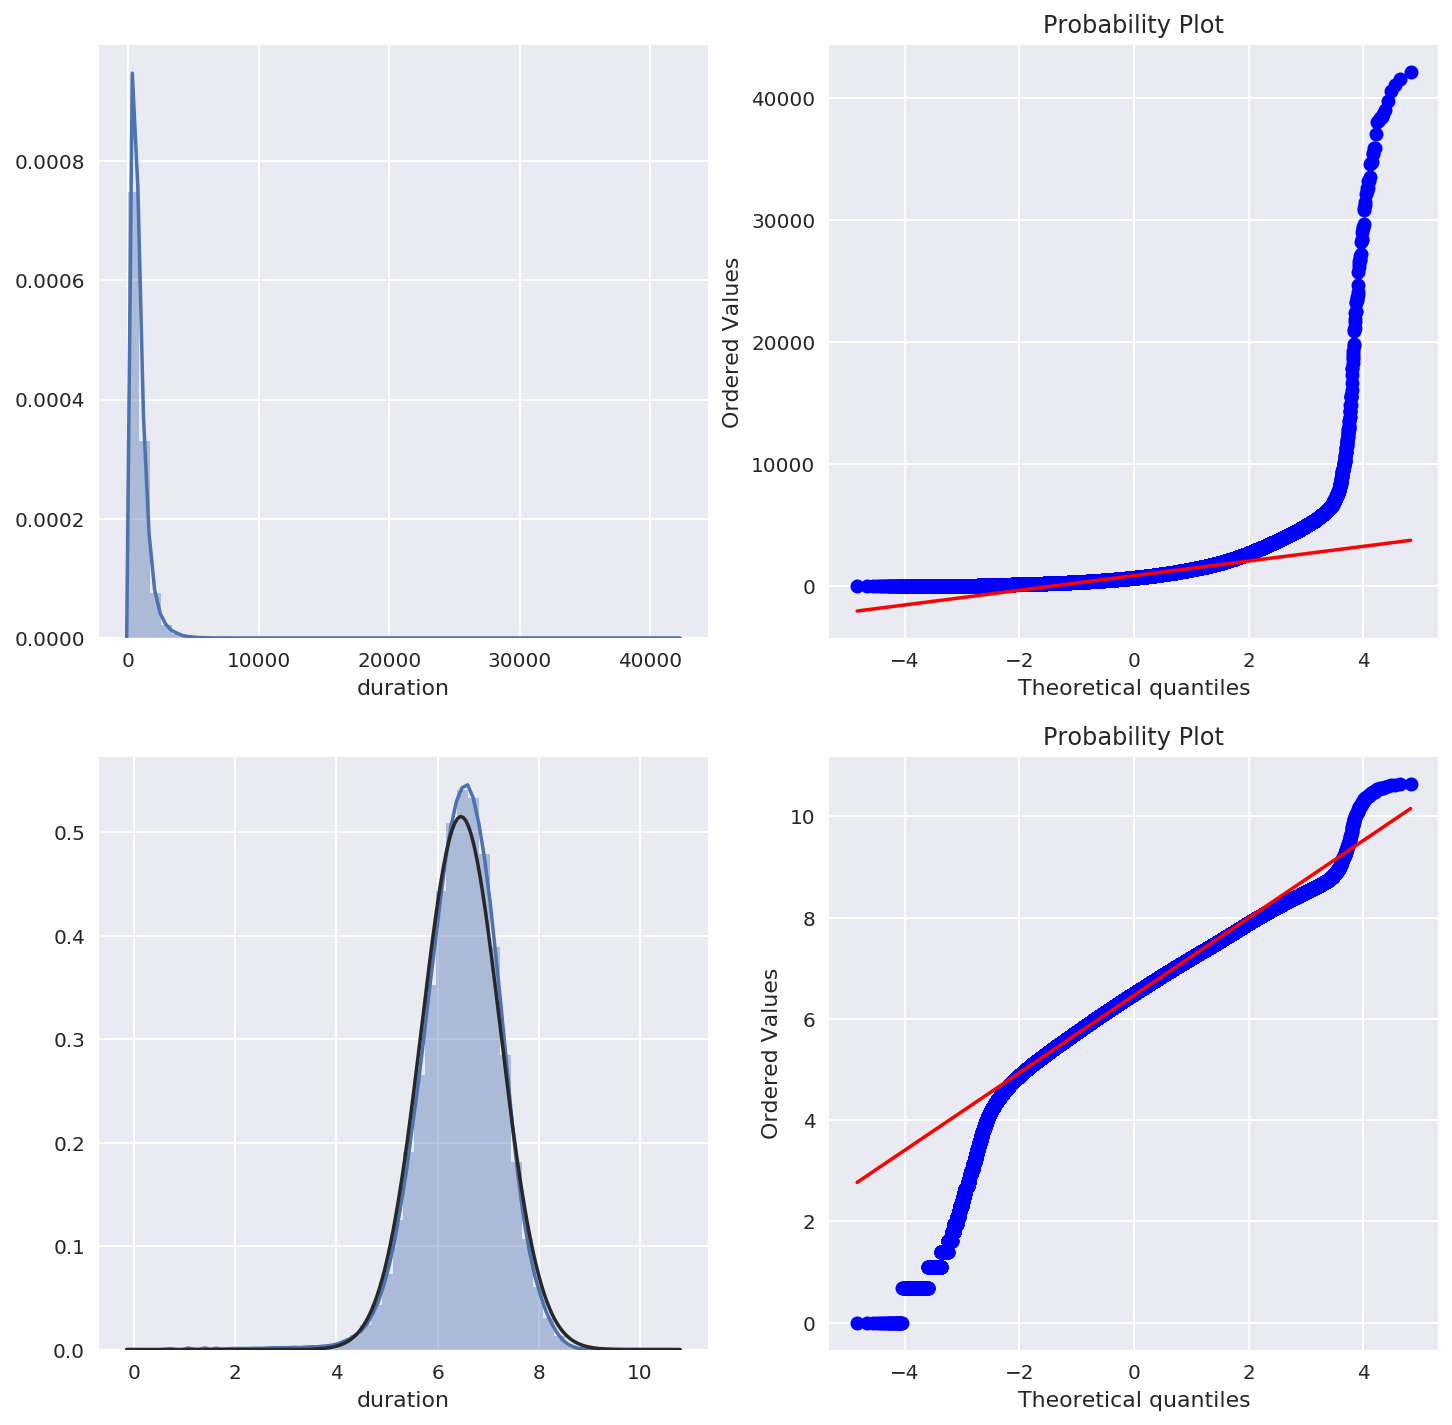

In [189]:
# Check Normality with histogram & QQ plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
sns.distplot(train["duration"], hist=True, kde=True, ax=axes[0,0])
stats.probplot(train["duration"], dist="norm", plot=axes[0,1])

log_duration = np.log(train["duration"])
sns.distplot(log_duration, hist=True, kde=True, fit=norm, ax=axes[1,0], label="log(duration)")
stats.probplot(log_duration, dist="norm", plot=axes[1,1])

# Check Normality with skewness & kurtosis
# Skewness = measure of symmetry (for Normal distribution = 0)
# Kurtosis = measure of heavy/light-tailed-ness (for Normal distribution = 0)
np.round(train["duration"].skew(),3) # durations are skewed right since min duration = 0
np.round(train["duration"].kurt(),3) # very heavy tailed distribution

np.round(log_duration.skew(),3) # almost symmetric
np.round(log_duration.kurt(),3) # very close to ideal value of 0; tails are slightly heavy


## Explore time covariate

Start timestamps are given in Unix epoch seconds. These values can be converted to components of UTC dates & times. From the plots below, there doesn't appear to be a strong correlation between duration and any of the components of trip start time other than "hour". Trips starting around 10am take slightly less time than those starting early in the morning or late in the night.

In [190]:
# split timestamp into components
utcdt = pd.to_datetime(train['start_timestamp'], unit='s')

train["year"] = utcdt.dt.year
train["month"] = utcdt.dt.month
train["month"] = train["month"].apply(lambda x: calendar.month_abbr[x])

train["dayofweek"] = utcdt.dt.weekday_name
train["dayofweek"] = train["dayofweek"].apply(lambda x: x[:3])

train["dayofmonth"] = utcdt.dt.day
train["dayofyear"] = utcdt.dt.dayofyear
train["hour"] = utcdt.dt.hour
train["minute"] = utcdt.dt.minute

train.head()


,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,year,month,dayofweek,dayofmonth,dayofyear,hour,minute
row_id,,,,,,,,,,,,,
4342580,-73.978127,40.748627,-73.990067,40.740070,1429708811,314,2015,Apr,Wed,22,112,13,20
5207423,-73.991547,40.750401,-73.998383,40.732113,1431206828,580,2015,May,Sat,9,129,21,27
11522994,-73.964523,40.767410,-73.983734,40.740929,1447891351,885,2015,Nov,Thu,19,323,0,2
8170164,-73.978554,40.753296,-73.990219,40.756660,1440572437,485,2015,Aug,Wed,26,238,7,0
7386495,-73.976494,40.756413,-73.982422,40.723511,1437298603,782,2015,Jul,Sun,19,200,9,36


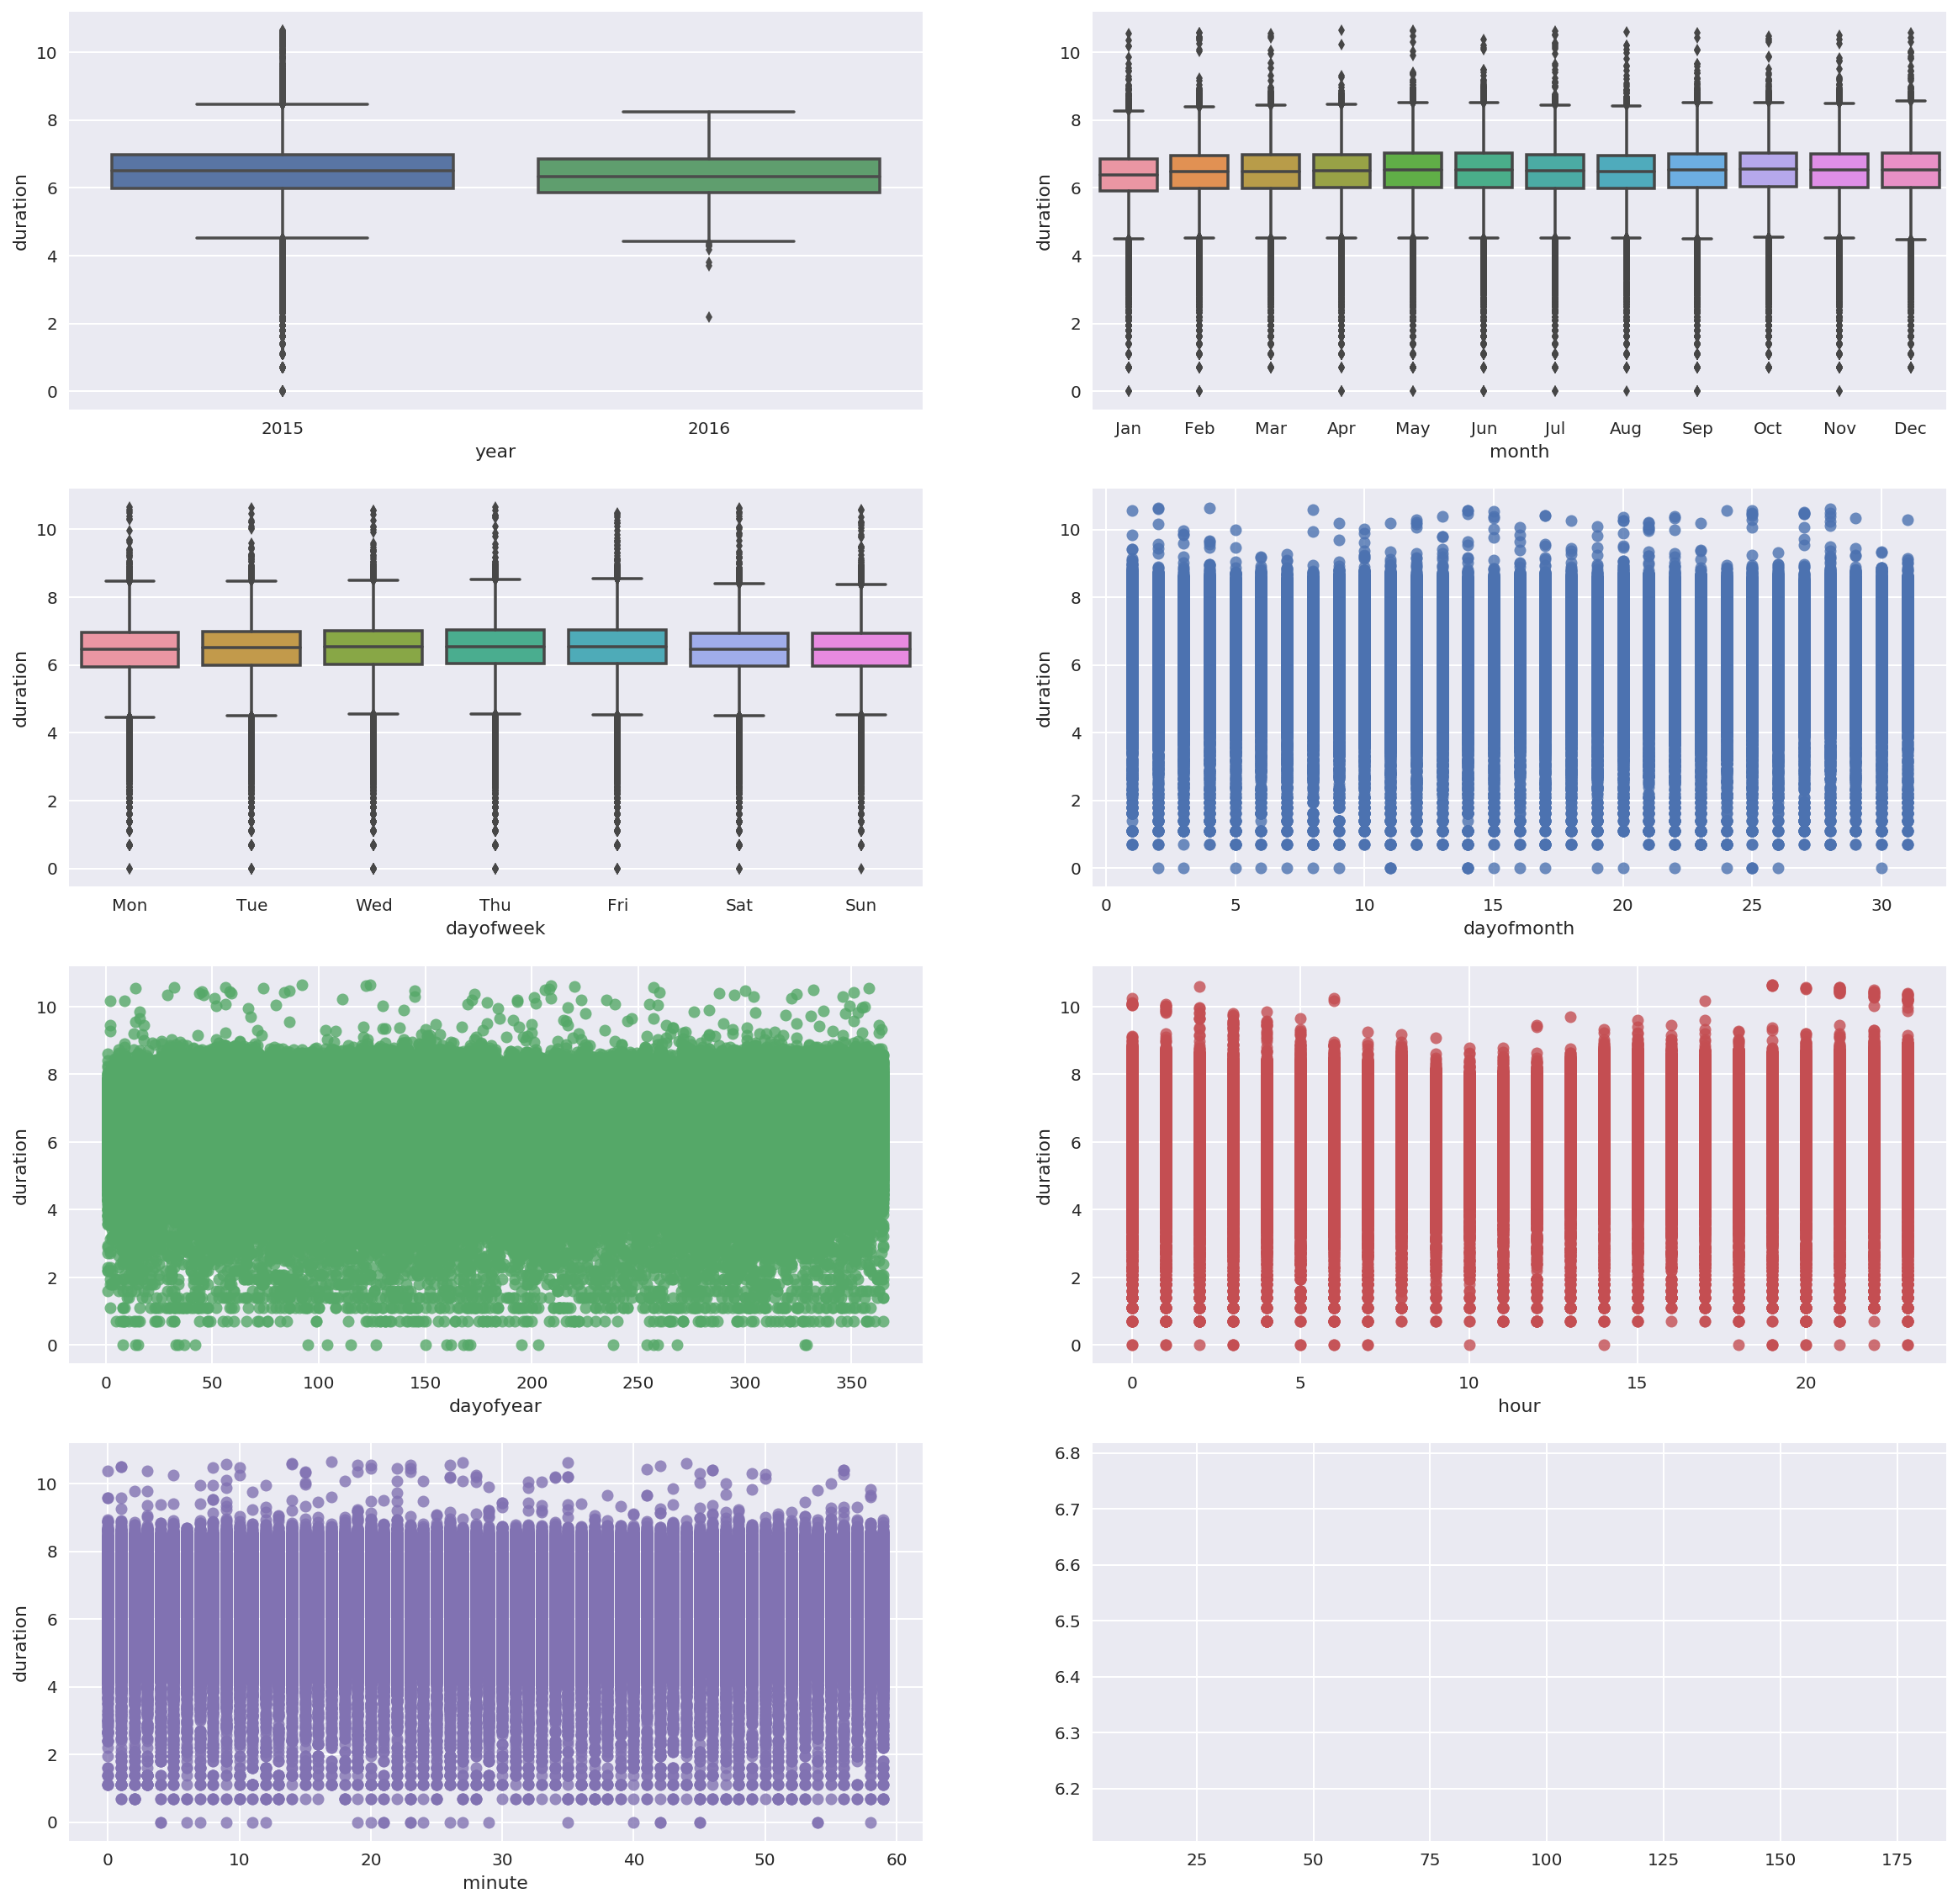

In [191]:
# Explore relationship between duration & start time components
fig, axes = plt.subplots(4, 2, figsize=(20,20))

sns.boxplot(x=train["year"], y=log_duration, ax=axes[0,0])
sns.boxplot(x=train["month"], y=log_duration, ax=axes[0,1], order=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

sns.boxplot(x=train["dayofweek"], y=log_duration, ax=axes[1,0], order=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
sns.regplot(x=train["dayofmonth"], y=log_duration, fit_reg=False, ax=axes[1,1])

sns.regplot(x=train["dayofyear"], y=log_duration, fit_reg=False, ax=axes[2,0])
sns.regplot(x=train["hour"], y=log_duration, fit_reg=False, ax=axes[2,1])

sns.regplot(x=train["minute"], y=log_duration, fit_reg=False, ax=axes[3,0])


## Explore location covariates

In [192]:
# Create unique locations
start = train["start_lng"].map(str) + ',' + train["start_lat"].map(str)
end = train["end_lng"].map(str) + ',' + train["end_lat"].map(str)

# Do locations occur more than once?
start.value_counts().head(10)
end.value_counts().head(10)


-74.186302,40.693142                     15
-73.874542,40.774109                     12
-73.9394,40.754692                       12
-73.948639,40.7449                       12
-73.874573,40.77412                      12
-74.00314300000001,40.727676             11
-73.77671099999999,40.645378             10
-73.874481,40.774071                     10
-73.87447399999999,40.773959999999995     9
-73.87455,40.77412                        9
dtype: int64

-74.186302,40.693142            15
-73.9394,40.754692              12
-73.948639,40.7449              12
-74.00314300000001,40.727676    11
-73.936501,40.758293             9
-73.992683,40.720501             8
-73.861839,40.768452             6
-73.862,40.768551                6
-73.994911,40.750149             5
-73.864861,40.77037              5
dtype: int64

The given longitude & latitude coordinates have a precision of 6 decimal places. This is sub-meter resolution. In order to generalize from this dataset, it is better to reduce precision and consider neighborhoods within 100m of original location instead of the original location itself. This is done by rounding up coordinates to 3 decimal places.

In [196]:
train["start_lng"] = np.round(train["start_lng"], 3)
train["start_lat"] = np.round(train["start_lat"], 3)
train["end_lng"] = np.round(train["end_lng"], 3)
train["end_lat"] = np.round(train["end_lat"], 3)

train.head() # verify rounding occured as expected

# Now see how often these "neighborhoods" occur
train["start_lng"].value_counts().head(10)
train["start_lat"].value_counts().head(10)
train["end_lng"].value_counts().head(10)
train["end_lat"].value_counts().head(10)


,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,year,month,dayofweek,dayofmonth,dayofyear,hour,minute
row_id,,,,,,,,,,,,,
4342580,-73.978,40.749,-73.990,40.740,1429708811,314,2015,Apr,Wed,22,112,13,20
5207423,-73.992,40.750,-73.998,40.732,1431206828,580,2015,May,Sat,9,129,21,27
11522994,-73.965,40.767,-73.984,40.741,1447891351,885,2015,Nov,Thu,19,323,0,2
8170164,-73.979,40.753,-73.990,40.757,1440572437,485,2015,Aug,Wed,26,238,7,0
7386495,-73.976,40.756,-73.982,40.724,1437298603,782,2015,Jul,Sun,19,200,9,36


-73.982    34281
-73.991    26925
-73.990    25406
-73.988    24770
-73.989    24607
-73.981    24534
-73.992    24321
-73.978    23555
-73.987    23326
-73.983    23144
Name: start_lng, dtype: int64

40.750    24148
40.774    23954
40.751    22482
40.756    22241
40.764    21349
40.762    20799
40.757    19885
40.763    19229
40.761    18671
40.752    18221
Name: start_lat, dtype: int64

-73.982    27438
-73.991    25429
-73.979    23552
-73.981    23210
-73.978    22710
-73.983    22575
-73.992    22526
-73.985    21752
-73.990    21395
-73.980    21324
Name: end_lng, dtype: int64

40.750    22671
40.756    21399
40.764    19247
40.751    19226
40.761    19151
40.762    18239
40.759    18063
40.765    17933
40.757    17713
40.758    17606
Name: end_lat, dtype: int64

In [ ]:
# Distance between points


In [ ]:
# Split training set into train & validation

In [ ]:
# Linear regression model; calculate Mean Abs Error

In [ ]:
# Compare to tree-based model